In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import pandas as pd
import numpy as np
import os
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt 
from math import isnan
import scipy.stats as ss
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.ensemble import *
from sklearn.inspection import *
from xgboost import XGBClassifier
from sklearn import metrics
import sklearn
import re
import plotly
import chart_studio.plotly as py
from scipy.cluster.hierarchy import *
from statsmodels.stats import multitest
import glob
from scipy.stats import spearmanr,pearsonr
import scipy
from scipy.io import mmread
from statannot import add_stat_annotation

## 2. Single Cell RNASeq

### 2.1 Prepare MTX Data

In [13]:
metadata = pd.read_csv('YOUR OWN METADATA.csv')
data = pd.read_csv('YOUR OWN DATA.csv')

(85238, 11)

### 2.2 Analysis

#### selected cells

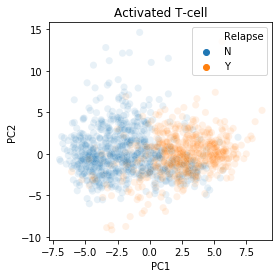

In [305]:
celltype = 'X'
label = metadata.loc[metadata['cell_type'] == celltype,:]['reoccur']
pca = KernelPCA(n_components=3,kernel='linear')
pc = pca.fit_transform(dense.loc[metadata['cell_type'] == celltype,:])
dpc = pd.DataFrame({'PC1':pc[:,0],'PC2':pc[:,1],'Relapse':label})
fig,ax = plt.subplots(figsize = (4,4))
sns.scatterplot(x = 'PC1',y = 'PC2',s = 50, data = dpc,alpha = 0.1, ax = ax,hue='Relapse')

{'N': 'c', 'Y': 'b'}


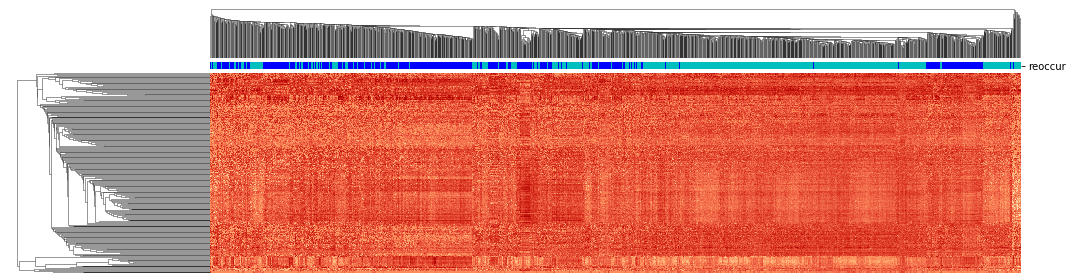

In [27]:
featc = PUT YOUR OWN DATA HERE
lut = dict(zip(label.unique(), "cb")) #color pallette
row_colors = label.map(lut)
g = sns.clustermap(featc.transpose(),xticklabels = False, 
                   yticklabels = False, cmap ='OrRd',col_colors = row_colors, figsize = (15,4), cbar_pos = None)
g.savefig('figures/heatmap_dense.jpg',dpi = 300, bbox_inches = 'tight')
print(lut)

### 2.3 Consider a Model for Activated T-cell

#### Dataframe slicing and select

In [28]:
featc = densc.loc[metadata['cell_type'] == 'X',:]
for i in range(featc.shape[1]):
    featc.iloc[:,i] = np.asarray(featc.iloc[:,i]) # sparse to matrix
targc = metadata.loc[metadata['cell_type'] == 'X',:]['reoccur']

#### User mutual information importance to select important features

In [29]:
#MI
Nrep = 50
mi = np.zeros((Nrep,featc.shape[1]))
for i in range(Nrep):
    skb = SelectKBest(score_func=mutual_info_classif, k=featc.shape[1])
    skb_fit = skb.fit(featc,targc)
    mi[i,:] = skb_fit.scores_

mi_mean = mi.mean(axis = 0)
mi_std = mi.std(axis = 0)
mi_mean = pd.Series(mi_mean)
mi_mean.index = featc.columns
#mi = mi/mi.sum()
mi_mean = mi_mean.sort_values(ascending = False)
mi_mean

4290     0.000433
5730     0.000404
13612    0.000000
5044     0.000000
5743     0.000000
           ...   
9320     0.000000
9163     0.000000
9119     0.000000
9108     0.000000
69       0.000000
Length: 235, dtype: float64

#### optimize number of features for prediction for a model

In [34]:
roc_all = []
prc_all = []
f1_all = []

pred_targert = 'xxx'
nfeat = np.arange(2,20)
bestpip = RandomForestClassifier(bootstrap=False, max_features=0.1, min_samples_leaf=3, min_samples_split=3, n_estimators=100)
cv = StratifiedKFold(n_splits=5, shuffle = True)

featc = featc.reset_index(drop = True)
targc = targc.reset_index(drop = True)

for kk in nfeat:
    select = mi_mean.index.values[:kk]
    featmod = featc[select]
    labeln = pd.Series(targc).map({'N':0,'Y':1})
    dtmod = pd.concat((featmod,labeln),axis = 1) 
    
    ytall = []
    ppall = []
    plall = []
    
    for i, (train, test) in enumerate(cv.split(featmod, labeln)):
        training_data = dtmod.iloc[train,:]
        #training_data = upsamplern(training_data,pred_targert)
        bestpip.fit(training_data.drop(pred_targert,axis = 1),training_data[pred_targert])
        ptest = bestpip.predict_proba(featmod.iloc[test,:])[:,1]
        ltest = bestpip.predict(featmod.iloc[test,:])
        ptrain = bestpip.predict_proba(featmod.iloc[train,:])[:,1]
        fpr,tpr,th = metrics.roc_curve(labeln[test],ptest,pos_label = 1)
        ytall.extend(list(labeln[test].values))
        ppall.extend(list(ptest))
        plall.extend(list(ltest))
    
    roc_all.append(metrics.roc_auc_score(ytall,ppall))
    f1_all.append(metrics.f1_score(ytall,plall,average = None))
    pre,rec,thr = metrics.precision_recall_curve(ytall,ppall,1)
    prc_all.append(metrics.auc(rec,pre))

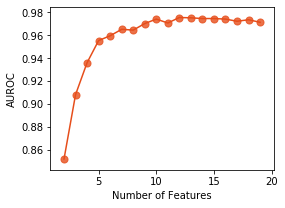

In [35]:
auroc = np.array(roc_all)
auprc = np.array(prc_all)
f1 = np.array(f1_all)
plt.figure(figsize = (4,3))
plt.plot(nfeat,auroc, '-',color = (0.9,0.3,0.1))
plt.scatter(nfeat,auroc,color = (0.9,0.3,0.1),s = 50, alpha = 0.8)
#plt.scatter(nfeat,auprc,color = (0.1,0.9,0.3),s = 10, alpha = 0.7)
#plt.scatter(nfeat,f1,color = (0.1,0.3,0.9),s = 30, alpha = 0.6)
plt.xlabel('Number of Features')
plt.ylabel('AUROC')
#plt.legend(['AUROC','F1 Score'],loc = 2)
plt.savefig('figures/number_feature_opt.svg',bbox_inches="tight")

### 2.4 Prediction

In [291]:
## Prediction
bestpip = RandomForestClassifier(bootstrap=False, max_features=0.1, max_depth=10, min_samples_leaf=3, min_samples_split=3, n_estimators=100)
select = mi_mean.index.values[:10]
featmod = featc[select]
labeln = pd.Series(targc).map({'N':0,'Y':1})
dtmod = pd.concat((featmod,labeln),axis = 1) 
pred_targert = 'xxx'

ytall = []
ppall = []
ypall = []
score1 = [] #precision
score2 = [] #recall
score3 = [] #AUROC
score4 = [] #F1
score5 = [] #accuracy score

cv = StratifiedKFold(n_splits=5,shuffle = True)
for i, (train, test) in enumerate(cv.split(featmod, labeln)):
    training_data = dtmod.iloc[train,:]
    #training_data = upsamplern(training_data)
    bestpip.fit(training_data.drop(pred_targert,axis = 1),training_data[pred_targert])
    ptest = bestpip.predict_proba(featmod.iloc[test,:])[:,1]
    ltest = bestpip.predict(featmod.iloc[test,:])
    ptrain = bestpip.predict_proba(featmod.iloc[train,:])[:,1]
    
    score1.append(np.mean(metrics.precision_score(labeln[test].values,ltest, average=None)))
    score2.append(np.mean(metrics.recall_score(labeln[test].values,ltest, average=None)))
    score3.append(metrics.roc_auc_score(labeln[test].values,ptest))
    score4.append(np.mean(metrics.f1_score(labeln[test].values,ltest, average=None)))
    score5.append(metrics.accuracy_score(labeln[test].values,ltest))
    
    ytall.extend(list(labeln[test].values))
    ppall.extend(list(ptest))
    ypall.extend(list(ltest))

print(np.mean(score1),np.std(score1))
print(np.mean(score2),np.std(score2))
print(np.mean(score3),np.std(score3))
print(np.mean(score4),np.std(score4))
print(np.mean(score5),np.std(score5))


0.9073152022413302 0.015185134347380233
0.9093726031599939 0.013610678226808124
0.9705271769698829 0.0045367717208886355
0.9080223845992016 0.014606250272152815
0.9092198581560285 0.014638132936560522


### 2.5 Plot a ROC curve

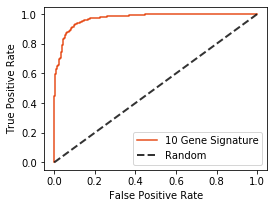

In [292]:
fig, ax1 = plt.subplots(figsize = (4,3))

fpr,tpr,th = metrics.roc_curve(ytall,ppall,pos_label = 1)
ax1.plot(fpr,tpr,label = 'Signature',color = (0.9,0.3,0.1))

ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
        label='Random', alpha=.8)

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend()
#ax1.set_title('AUROC = 0.77')
plt.savefig('figures/roc_sig.svg',bbox_inches="tight")